Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
#Supress Warnings
import warnings 
warnings.filterwarnings('ignore')

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#Generates a tf.data.Dataset from the image files in the directory.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )##todo


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

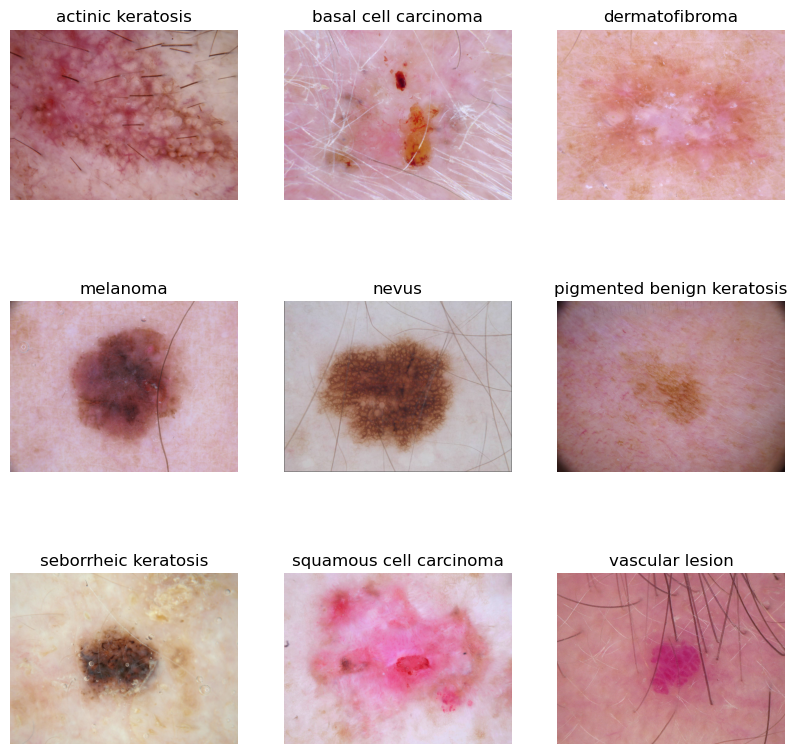

In [9]:
#Visualize one instance of all the 9 classes
import glob
#retrieve one image from each class folder
import matplotlib.image as mpimg

instance_file_path = []
instance_class_name = []
dir_train= os.listdir(data_dir_train)
#get one file path from each folder
for dir_name in dir_train:
    path = str(data_dir_train) +"/"+ dir_name
    for file_name in glob.iglob(path+'/*.jpg', recursive=True):
        #print(file_name)
        instance_file_path.append(file_name)
        instance_class_name.append(dir_name)
        break


#display one image from each class folder
plt.figure(figsize=(10,10))
for i in range(len(instance_class_name)):
    ax = plt.subplot(3,3,i+1) 
    img = mpimg.imread(instance_file_path[i])
    plt.imshow(img)
    plt.axis("off")
    plt.title(instance_class_name[i])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h1 style = "color : Red"> Model 1</h1>
<h3 style = "color : Blue"> Adding 3 Convolutional layers,using activation function as "relu"</h3>

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
num_class = 9
model = tf.keras.Sequential([
      # adding 1st CNN layer
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
       # adding 2nd CNN layer
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
       # adding 3rd CNN layer
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
        
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
# compiling the model and using optimizer as 'adam'
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 32s 308ms/step - loss: 2.0029 - accuracy: 0.2556 - val_loss: 1.7940 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 21s 378ms/step - loss: 1.6054 - accuracy: 0.4414 - val_loss: 1.6077 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 25s 444ms/step - loss: 1.4521 - accuracy: 0.5017 - val_loss: 1.4338 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 21s 372ms/step - loss: 1.2935 - accuracy: 0.5385 - val_loss: 1.3642 - val_accuracy: 0.5481
Epoch 5/20
56/56 [==============================] - 21s 368ms/step - loss: 1.1990 - accuracy: 0.5804 - val_loss: 1.4493 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 22s 390ms/step - loss: 1.1138 - accuracy: 0.6010 - val_loss: 1.6004 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 22s 395ms/step - loss: 1.0479 - accuracy: 0.6166 - val_loss: 1.3424 - val_accuracy: 0.5772

### Visualizing training results

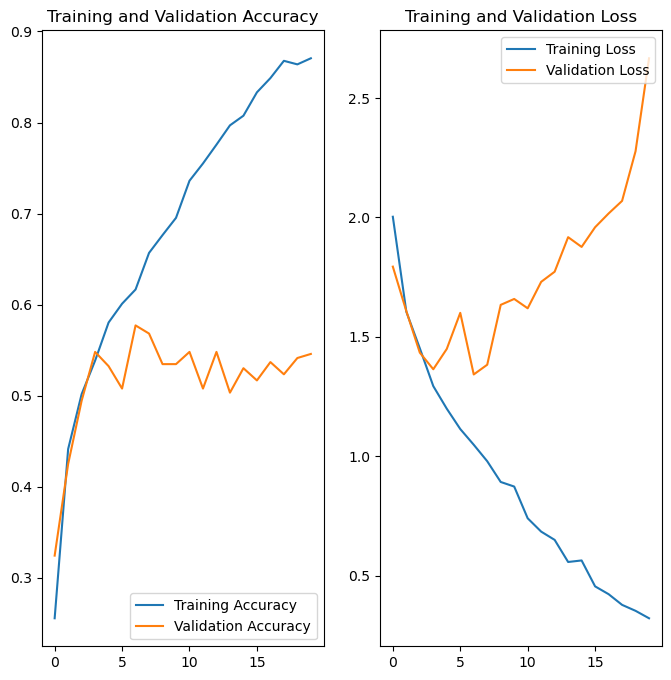

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

<h1 style = "color : Red"> Model 1 :- Findings</h1>
<h3 style = "color : Blue"> Model has definitely overfitted the training data because of the following reasons</h3>

<li> Training accuracy is very high which is almost 89%, however the validation accuracy is around 50%. 
<li> The loss on the validation data decreased intially for few epochs,however after that, with every epoch it kept increasing
<li> Model has memorized the training data which resulted in poor validation accuracy

<h1 style = "color : Red"> Model 2</h1>

<h3 style = "color : Blue"> Using augmentation strategy as "horizontal_and_vertical", using dropouts in layers</h3>

In [16]:
# applying augmentation to the model 
aug_data = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1), 
])

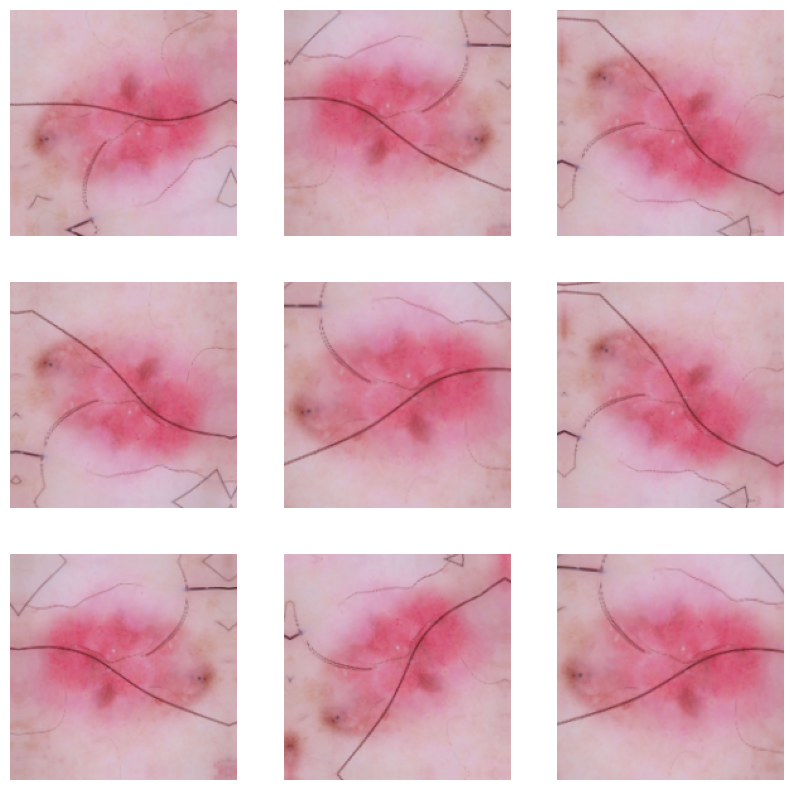

In [17]:
# visualizing how the augmentation strategy has worked for one instance of training image.        
for img,labels in train_ds.take(1):
    image=img[0]
    image=tf.reshape(image,(1,img_width,img_height,3))

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = augmented_data(image)[0]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [18]:
model = tf.keras.Sequential([
    aug_data,
     # adding 1st CNN layer
    layers.Rescaling(scale = 1./255),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
      # adding 2nd CNN layer
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
       # adding 3rd CNN layer
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compiling the model

In [19]:
## compile model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [20]:
## train model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) 

Epoch 1/20
56/56 [==============================] - 27s 460ms/step - loss: 1.8927 - accuracy: 0.3036 - val_loss: 1.6201 - val_accuracy: 0.4295
Epoch 2/20
56/56 [==============================] - 25s 441ms/step - loss: 1.5878 - accuracy: 0.4319 - val_loss: 1.4741 - val_accuracy: 0.4810
Epoch 3/20
56/56 [==============================] - 28s 498ms/step - loss: 1.4958 - accuracy: 0.4844 - val_loss: 1.5168 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 28s 509ms/step - loss: 1.4031 - accuracy: 0.5039 - val_loss: 1.4339 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 25s 454ms/step - loss: 1.3906 - accuracy: 0.5179 - val_loss: 1.4138 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 25s 454ms/step - loss: 1.3173 - accuracy: 0.5363 - val_loss: 1.3780 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 28s 493ms/step - loss: 1.3331 - accuracy: 0.5240 - val_loss: 1.3799 - val_accuracy: 0.5101

### Visualizing the results

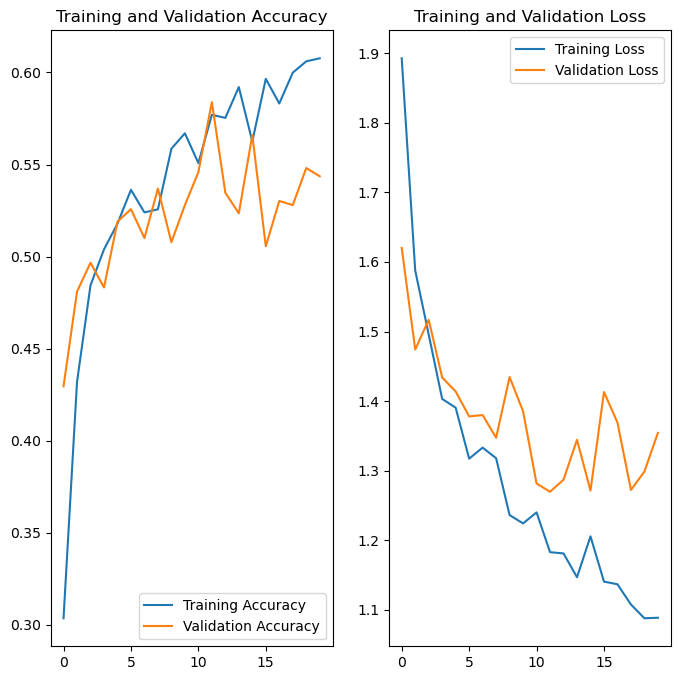

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
<h1 style = "color : Red"> Model 2 :- Findings</h1>
<h3 style = "color : Blue"> Model has eliminated the overfitting problem</h3>

<li> Data augmentation and dropout has helped eliminate the problem of overfitting
<li> The training and validation accuracy is proportionate now so it proves that model is fairly doing its job
<li> The loss has decreased with each epoch for both training and validation data, which is again a good trait

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

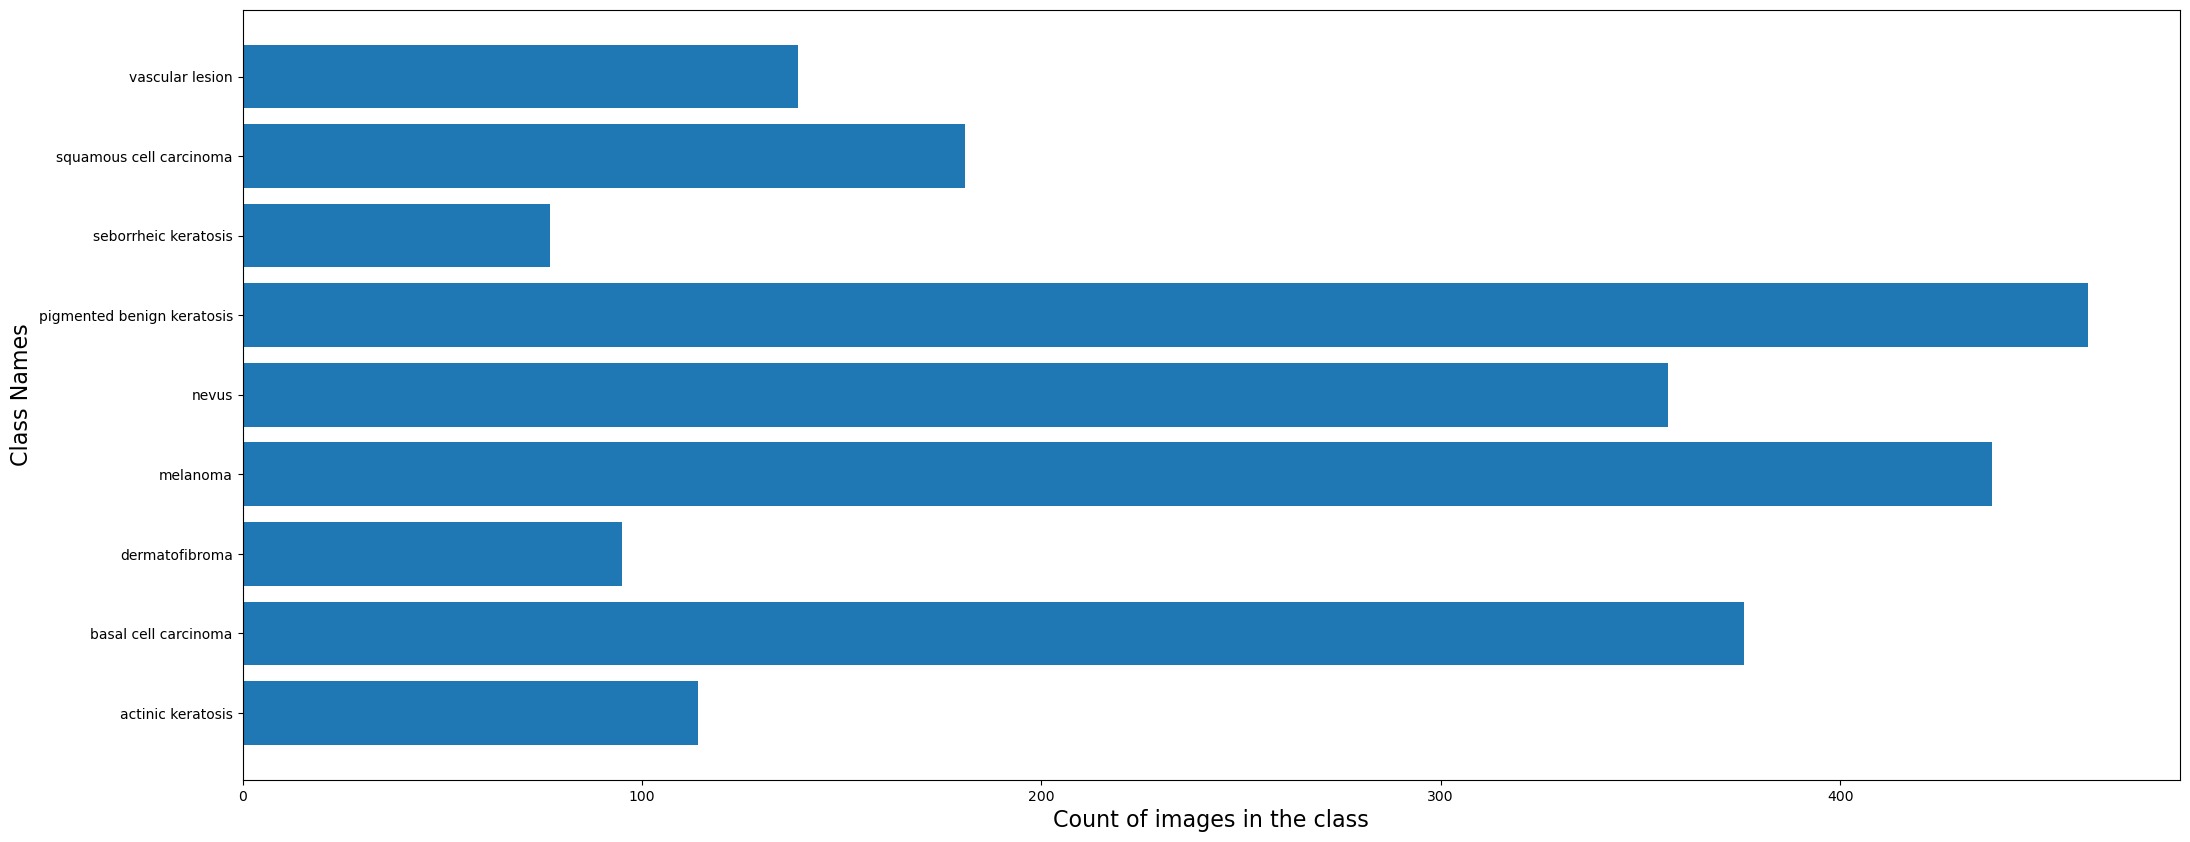

In [11]:
import seaborn as sns;
image_path=[]
class_identifier=[]

for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        image_path.append(str(j))
        class_identifier.append(i)
dataframe_dict_original = dict(zip(image_path, class_identifier))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.ylabel('Class Names', fontsize=16)                              
plt.xlabel('Count of images in the class', fontsize=16)
plt.barh(class_names,class_count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
<h3 style = "color : Blue"><li> seborrheic keratosis</h3>

#### - Which classes dominate the data in terms proportionate number of samples?
<h3 style = "color : Blue"> <li> pigmented benign keratosis
<li> melanoma
<li> basal cell carcinoma
<li> nevus</h3>


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability = 0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A2EB08FAF0>: 100%|██████████| 500/500 [00:04<00:00, 102.01 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A282541E80>: 100%|██████████| 500/500 [00:05<00:00, 96.16 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A2B472E370>: 100%|██████████| 500/500 [00:05<00:00, 90.16 Samples/s]                   


Initialised with 438 image(s) found.
Output directory set to Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2A282A7C9D0>: 100%|██████████| 500/500 [00:30<00:00, 16.59 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x2A2EC291DC0>: 100%|██████████| 500/500 [00:27<00:00, 18.07 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A282803370>: 100%|██████████| 500/500 [00:05<00:00, 94.85 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2A282788E80>: 100%|██████████| 500/500 [00:11<00:00, 41.83 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A2D052B970>: 100%|██████████| 500/500 [00:05<00:00, 89.19 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2A2A243CAF0>: 100%|██████████| 500/500 [00:05<00:00, 93.30 Samples/s]                   


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_21dfe5b9-8c59-4ca2-9fda-ca294bea0cd4.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_264bedad-8fa5-4689-974e-e4bf8c3021de.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a06396ea-495c-4701-9b92-d65deec5b087.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c1c4d35b-f8cb-4e56-98ad-914359ffe0d4.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f0a36281-dd30-4983-a569-642b3062f0ee.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_1c3d6298-29d4-480f-be35-eac8adb554e4.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a640e1ea-689b-4c7e-a8f5-52d9f6fc89ab.jpg',
 'Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_d35a94a3-9bce-42aa-aec1-686cf5793cd8.jpg',
 'Train\\actinic

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [30]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

### Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

### Creating a training dataset

In [32]:
data_dir_train="Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Creating a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<h1 style = "color : Red"> Model 3</h1>
<h3 style = "color : Blue"> Using batch Normalization along with dropout </h3>

In [34]:
model = tf.keras.Sequential([
    aug_data,
     # adding 1st CNN layer
    layers.Rescaling(scale = 1./255),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    # adding 2nd CNN layer
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    # adding 3rd CNN layer
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
  
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

# Compile Model 3

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train Model 3

#### Train model 3 for 50 epochs

In [36]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 135s 783ms/step - loss: 2.3331 - accuracy: 0.3325 - val_loss: 22.1768 - val_accuracy: 0.0831
Epoch 2/50
169/169 [==============================] - 127s 748ms/step - loss: 1.5318 - accuracy: 0.4288 - val_loss: 11.7359 - val_accuracy: 0.1262
Epoch 3/50
169/169 [==============================] - 143s 841ms/step - loss: 1.3813 - accuracy: 0.4798 - val_loss: 2.5201 - val_accuracy: 0.2903
Epoch 4/50
169/169 [==============================] - 140s 820ms/step - loss: 1.2971 - accuracy: 0.5037 - val_loss: 1.7049 - val_accuracy: 0.4046
Epoch 5/50
169/169 [==============================] - 121s 710ms/step - loss: 1.2182 - accuracy: 0.5302 - val_loss: 1.1558 - val_accuracy: 0.5716
Epoch 6/50
169/169 [==============================] - 111s 653ms/step - loss: 1.1954 - accuracy: 0.5391 - val_loss: 1.1793 - val_accuracy: 0.5657
Epoch 7/50
169/169 [==============================] - 114s 673ms/step - loss: 1.1668 - accuracy: 0.5427 - val_loss: 1.3369

####  Visualize the model results for 50 epochs

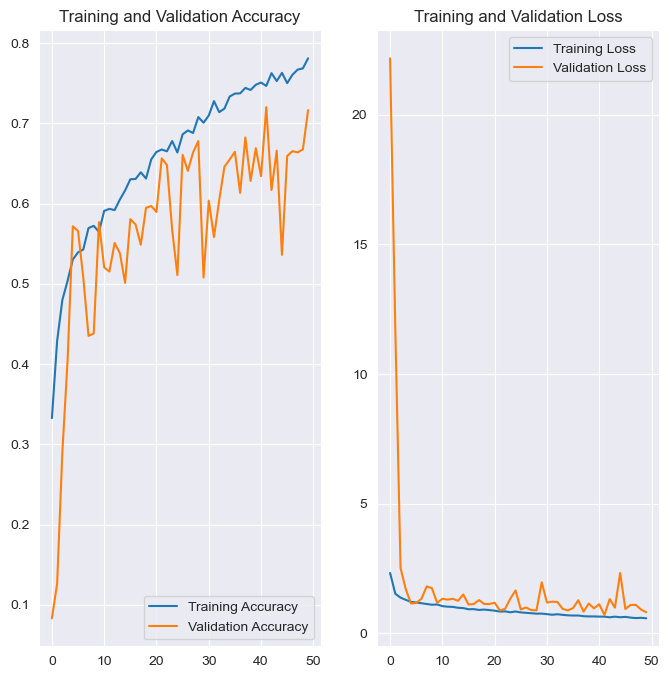

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

<h1 style = "color : Red"> Model 3 :- Findings</h1>
<h3 style = "color : Blue"> Model has achieved good accuracy</h3>

<li> Firstly we have tackled overfitting issue using data augmentation and dropout
<li> We then tried to improve the accuracy using batch normalization
<li> Class rebalance also helped to get the model at par and tackled the problem of data sparcity     
<li> All this techniques and tweaks has proven helpful in improvising the model
<li> Finally model has scored a good accuracy on training data which is around 81% and on validation data which is around 71%  
